# Step 5: Design the opposite query 

In this notebook, we are going to design the prompt for opposite query generation.

This is part of the ranking algorithm design.  Since one product can have multiple reviews, a similarity search can return multiple results for a single product. There could be chances that the results are contradicting. We are going to use LLM to generate opposite queries against the original query. The intuition behind this opposite query concept is if the returning result for a product contains reviews close to the original query and the opposite queries, the resulting score for this product would be lowered due to the “cancellation effect”. 

In [1]:
# install the faiss-cpu when new env is provisioned
#!pip install faiss-cpu
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021

In [2]:
# install the openai when new env is provisioned
#!pip install openai

#conda install -c conda-forge openai

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import umap
import faiss
import openai
import pandas as pd
import numpy as np
import altair as alt
import configparser
from PIL import Image


### Prepare required resources

In [4]:
df_apparel = pd.read_csv('../resources/data/apparel_15to25.tsv.gz', sep='\t', compression='gzip')
cols = ['product_id', 'review_id', 'star_rating', 'product_title', 'review_body']
df_apparel = df_apparel[cols]
df_apparel.head(3)

,product_id,review_id,star_rating,product_title,review_body
0,245600258X,RZER3NRRB523C,4.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,Quickly tore on one side. A very nice and com...
1,245600258X,RDNDYIC6MH3Q5,4.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,One size smaller would have been fine. I had ...
2,245600258X,R1Z0YOWJGWESSD,5.0,La Leela Hawaiian Shirt For Men Short Sleeve F...,"Great Hawaiian shirt. Very comfortable, loose..."


In [5]:
# Load the pre-created FAISS index
faiss_index = faiss.read_index('../resources/binary/apparel_15to25_review_cosine.faissindex')

In [6]:
# Load your API key from an environment variable or secret management service
config = configparser.ConfigParser()
config.read('nes.ini')
openai.api_key = config['OpenAI']['api_key']

### Define helper functions

In [7]:
# Helper function to create the query embedding. Make sure to use the same model as what we used to created the product embedding
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'], dtype='float32').reshape(1, -1)

In [8]:
def search_with_original_query(df, faiss_index, query_embedding, num_of_records=100):
    # we need to normalize the question embedding in order to use cosine similarity to search 
    faiss.normalize_L2(query_embedding)

    # distance is the correspnding distance
    # result_idx is the index of the input array, hence the index of the dataframe (if the dataframe index is reset which starts with 0)
    distance, result_idx = faiss_index.search(query_embedding, k=num_of_records)

    # use the return index to create the result dataframe
    df_result = df.iloc[result_idx.squeeze().tolist()]
    # add Distance to the result dataframe
    df_result['distance'] = distance.T

    df_result = df_result.sort_values(by='distance', ascending=True)
    
    return df_result, result_idx

In [9]:
def generate_opposite_query(orignal_query='', prompt=''):

    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=prompt.format(orignal_query),
        temperature=0,
        max_tokens=1000,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )

    return response['choices'][0]['text']

In [10]:
def search_with_opposite_query(df, faiss_index, opposite_query_embedding, original_query_result_index, num_of_records=100):

    faiss.normalize_L2(opposite_query_embedding)

    # we want to make sure the opposite query only compare against the texts found by the original query 
    id_selector = faiss.IDSelectorArray(original_query_result_index.shape[1], faiss.swig_ptr(original_query_result_index))
    filtered_distances, filtered_indices = faiss_index.search(opposite_query_embedding, k=num_of_records, params=faiss.SearchParametersIVF(sel=id_selector))

    df_opposite_result = df.iloc[filtered_indices.squeeze().tolist()]
    df_opposite_result['distance'] = filtered_distances.T

    df_opposite_result = df_opposite_result.sort_values(by='distance', ascending=False)

    return df_opposite_result

In [11]:
def get_reconcile_result(df_result_original, df_result_opposite):

    df_reconcile_result = df_result_original.merge(df_result_opposite[['review_id', 'distance']], 
                            left_on='review_id', right_on='review_id', how='left', suffixes=('_original', '_opposite'))
    
    # Using Dot Product FAISS Index with L2 normaliztion, the returning result is Cosine Similiarty, rather than Distance.
    # There will turn the Cosine Similarity to Distance 
    df_reconcile_result['distance_original'] = 1 - df_reconcile_result['distance_original']
    df_reconcile_result['distance_opposite'] = 1 - df_reconcile_result['distance_opposite']

    return df_reconcile_result

In [12]:
def plot_distances(df_input, title=''):
    df = df_input.copy()
    df = df[['distance_original', 'distance_opposite']]
    df['distance_original'] = df['distance_original'].astype('float64')
    df['distance_opposite'] = df['distance_opposite'].astype('float64')
    df = df.reset_index(drop=True).reset_index()
    df.columns=['index', 'original_query', 'opposite_query']
    df = df.melt(id_vars=['index'])

    domain = ['original_query', 'opposite_query']
    range_ = ['dodgerblue', 'coral']

    chart = alt.Chart(data=df).mark_line().encode(
            x=alt.X('index:Q').title('Record Index'),
            y=alt.Y("value:Q").scale(domain=(0,0.4)).title('Cosine Distance'),
            color=alt.Color("variable:N").scale(domain=domain, range=range_)
        ).properties(
            width=350,
            height=150,
            title=title
        )
    
    return chart

## Test with different designs of opposite query 

### Define the original query and get the corresponding search result

In [13]:
#query = "Long thin cotton socks for men, need to be breathable, even feeling cool for summer time."
query = "Wrinkle free chiffon blouse, sleek style, long sleeve, slim fit, with comfortable inside layer"

# create the embedding for orignal query 
query_embedding = get_embedding(query)

# search the FAISS index with orignal query embedding 
df_result_original, result_idx = search_with_original_query(df_apparel, faiss_index, query_embedding, num_of_records=100)

### Opposite Query Option 1 
Rewrite the original query by change the adjectives into their opposite meaning

In [14]:
prompt="""
    You are an English teacher. You need to find every single adjective from the sentences delimited by triple backquotes below.
    Then you rewrite the sentences by changing the adjectives in their opposite meaning. 
    Finally, you only need to output the rewritten sentences.

    ```{}```
"""

In [15]:
# generate opposite query rewrite
opposite_query_rewrite = generate_opposite_query(query, prompt)

# get the embedding for the opposite query 
opposite_query_embedding = get_embedding(opposite_query_rewrite)

# search the FAISS index with the opposite query. We need to pass the result_idx from the orignal query in order to limit the seach scope 
df_result_opposite = search_with_opposite_query(df_apparel, faiss_index, opposite_query_embedding, result_idx, num_of_records=100)

# generate the reconsile result 
df_reconcile_result = get_reconcile_result(df_result_original, df_result_opposite)

print(f"Original Query === {query}")
print(f"Opposite Query (Rewrite)=== {opposite_query_rewrite}")

Original Query === Wrinkle free chiffon blouse, sleek style, long sleeve, slim fit, with comfortable inside layer
Opposite Query (Rewrite)=== 
Wrinkle-ridden chiffon blouse, bulky style, short sleeve, baggy fit, with uncomfortable inside layer.


In [16]:
chart = plot_distances(df_input=df_reconcile_result, title='Rewrite Whole Query')

# uncomment below line to save the vis
#chart.save('../resources/img/design_opposite_query_rewrite_whole_query.png')

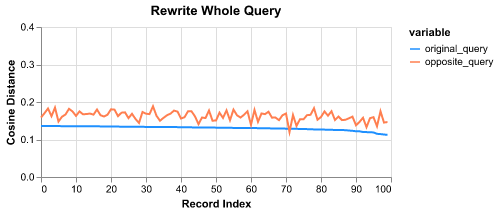

In [17]:
Image.open('../resources/img/design_opposite_query_rewrite_whole_query.png')

### Opposite Query Option 2
Just use the anthonyms of the adjectives from the original query, plus their corresponding meanings

In [18]:
prompt ="""
    You are an English teacher. You need to find every single ADJECTIVE from the sentences delimited by triple backquotes below.
    Then, you transform every adjective into its antonym.
    Finally, give the dictionary meaning for each antonym.
    Below are two examples. You need to comlete the third one. 
    

    Text 1: Kids flip flops for girl, cute, good fit, comfortable and durable, low price
    Output 1: Artless means without guile or deception. Unsuited means not proper or fitting for something. Uncomfortable means causing discomfort.  Fragile means easily broken. Costly means expensive.
    ## 
    Text 2: Long sleeve shirts for men. Wrinkle-free, thick but breathable and slim fit
    Output 2: Short means having little length. Crinkle means to form many short bends or ripples. Thin means measuring little in cross section or diameter. Airtight means impermeable to air or nearly so. Wide means having a greater than usual measure across
    ##
    Text 3:  ```{}```
    Output 3:
"""

In [19]:
# generate opposite query rewrite
opposite_query_rewrite = generate_opposite_query(query, prompt)

# get the embedding for the opposite query 
opposite_query_embedding = get_embedding(opposite_query_rewrite)

# search the FAISS index with the opposite query. We need to pass the result_idx from the orignal query in order to limit the seach scope 
df_result_opposite = search_with_opposite_query(df_apparel, faiss_index, opposite_query_embedding, result_idx, num_of_records=100)

# generate the reconsile result 
df_reconcile_result = get_reconcile_result(df_result_original, df_result_opposite)

print(f"Original Query === {query}")
print(f"Opposite Query (Rewrite)=== {opposite_query_rewrite}")

Original Query === Wrinkle free chiffon blouse, sleek style, long sleeve, slim fit, with comfortable inside layer
Opposite Query (Rewrite)=== Wrinkled means having many creases or folds. Clumsy means lacking grace in movement or posture. Short means having little length. Bulky means large and unwieldy. Uncomfortable means causing discomfort.


In [20]:
chart = plot_distances(df_input=df_reconcile_result, title='Antonym with Meaning Only')

# uncomment below line to save the vis
#chart.save('../resources/img/design_opposite_query_antonym.png')

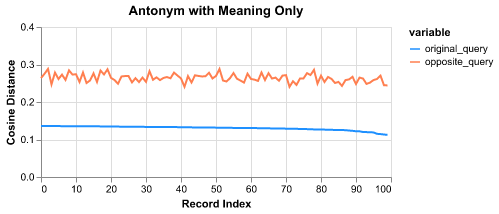

In [21]:
Image.open('../resources/img/design_opposite_query_antonym.png')